In [1]:
from pathlib import Path
import os
from collections import Counter

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

DATA_DIR = Path("dataset")  # change if needed
assert DATA_DIR.exists(), f"Dataset not found: {DATA_DIR}"

print("Found classes:")
for cls in sorted(os.listdir(DATA_DIR)):
    print(" -", cls)


Found classes:
 - 3ayn
 - 7aa
 - Alif
 - baa
 - dad
 - dal
 - faa
 - ghayn
 - haa
 - hamza
 - hamzaLnbra
 - jim
 - kaf
 - khaa
 - lam
 - lamAlif
 - mim
 - non
 - qaf
 - raa
 - sad
 - shin
 - sin
 - ta2
 - ta2marbota
 - taa
 - thaa
 - waw
 - yaa
 - za2
 - zal
 - zay


Number of images per class:
3ayn: 516
7aa: 524
Alif: 524
baa: 528
dad: 526
dal: 515
faa: 519
ghayn: 520
haa: 519
hamza: 121
hamzaLnbra: 244
jim: 518
kaf: 526
khaa: 514
lam: 524
lamAlif: 198
mim: 516
non: 519
qaf: 521
raa: 534
sad: 521
shin: 509
sin: 528
ta2: 525
ta2marbota: 264
taa: 526
thaa: 531
waw: 260
yaa: 646
za2: 524
zal: 504
zay: 524


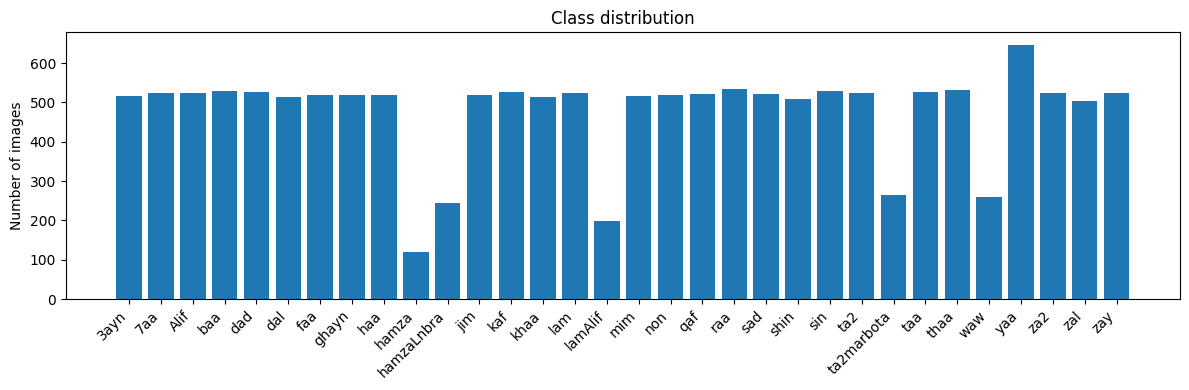

In [ ]:
class_counts = {}

for cls in sorted(os.listdir(DATA_DIR)):
    cls_dir = DATA_DIR / cls
    if not cls_dir.is_dir():
        continue
    count = sum(
        1 for f in os.listdir(cls_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    )
    class_counts[cls] = count

# Print
print("Number of images per class:")
for cls, cnt in class_counts.items():
    print(f"{cls}: {cnt}")

# Bar plot
plt.figure(figsize=(12, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of images")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


In [3]:
sizes = []

for cls in sorted(os.listdir(DATA_DIR)):
    cls_dir = DATA_DIR / cls
    if not cls_dir.is_dir():
        continue

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            continue
        fpath = cls_dir / fname
        try:
            with Image.open(fpath) as img:
                w, h = img.size
                sizes.append((w, h))
        except Exception as e:
            print("Error reading", fpath, "->", e)

len(sizes)


15288

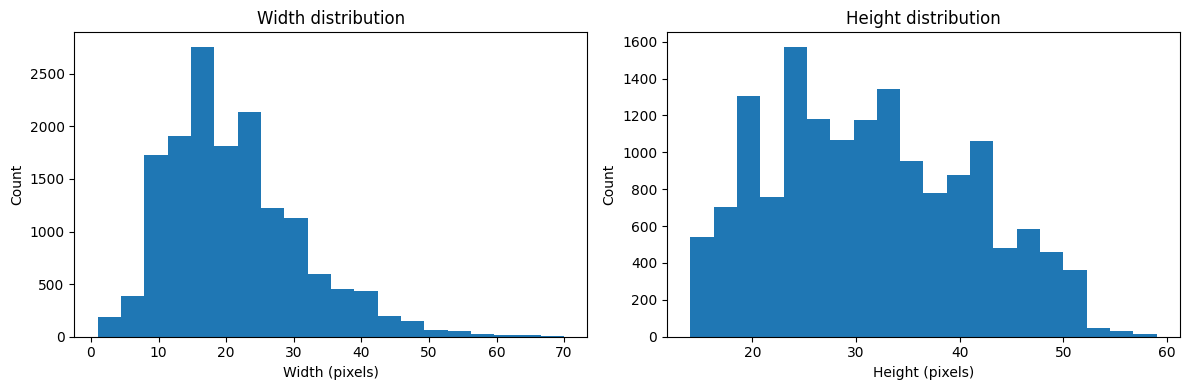

Min width: 1 Max width: 70
Min height: 14 Max height: 59


In [4]:
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20)
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.title("Width distribution")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20)
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.title("Height distribution")

plt.tight_layout()
plt.show()

print("Min width:", min(widths), "Max width:", max(widths))
print("Min height:", min(heights), "Max height:", max(heights))


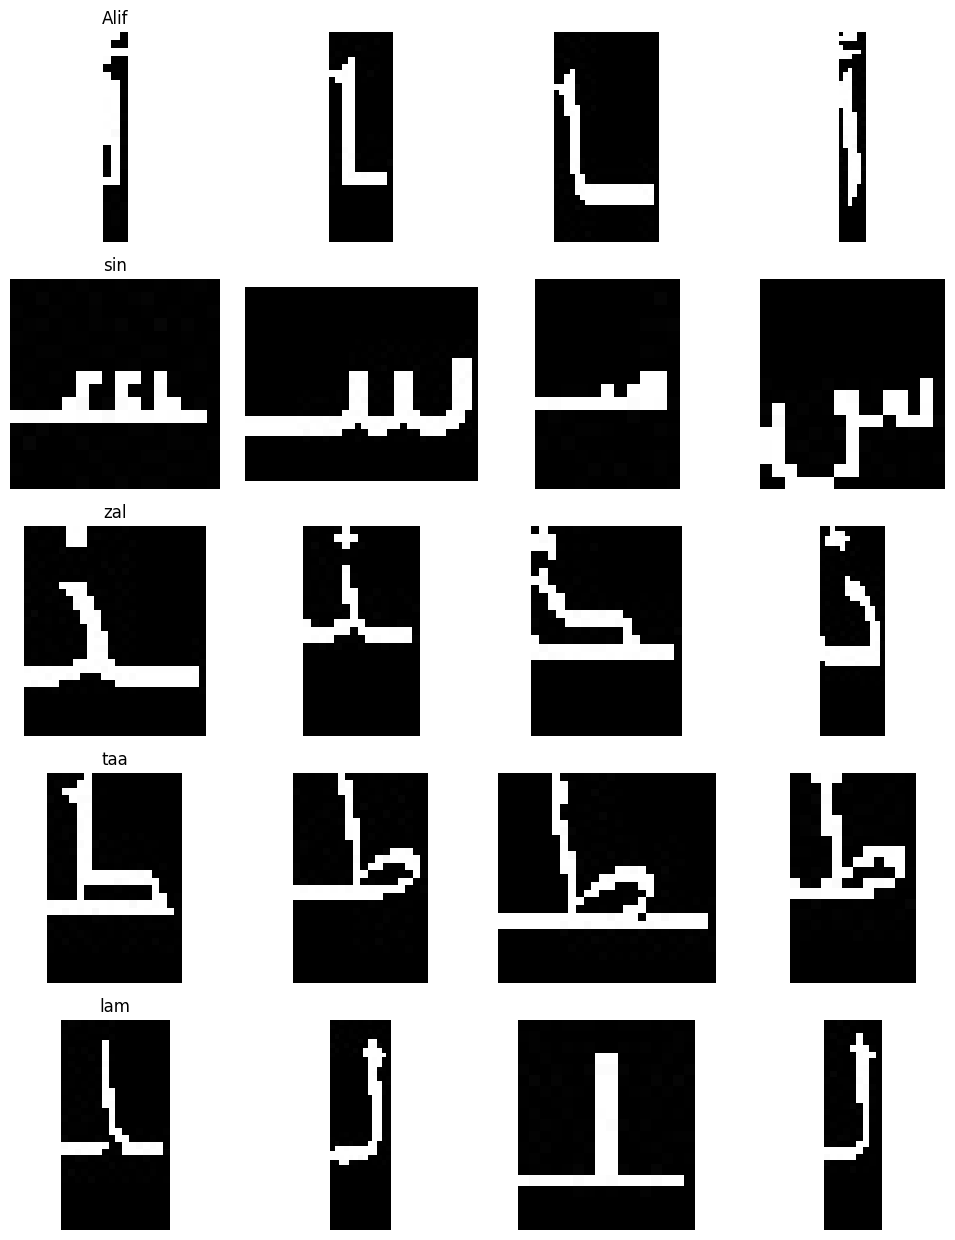

In [5]:
import random

def show_random_samples_per_class(n_classes=5, n_per_class=4):
    classes = sorted([d for d in os.listdir(DATA_DIR) if (DATA_DIR / d).is_dir()])
    classes = random.sample(classes, min(n_classes, len(classes)))

    plt.figure(figsize=(n_per_class * 2.5, n_classes * 2.5))

    for row, cls in enumerate(classes):
        cls_dir = DATA_DIR / cls
        files = [
            f for f in os.listdir(cls_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
        ]
        if not files:
            continue

        samples = random.sample(files, min(n_per_class, len(files)))

        for col, fname in enumerate(samples):
            fpath = cls_dir / fname
            with Image.open(fpath) as img:
                img_gray = img.convert("L")
                ax = plt.subplot(n_classes, n_per_class, row * n_per_class + col + 1)
                ax.imshow(img_gray, cmap="gray")
                ax.axis("off")
                if col == 0:
                    ax.set_title(cls)

    plt.tight_layout()
    plt.show()

show_random_samples_per_class(n_classes=5, n_per_class=4)


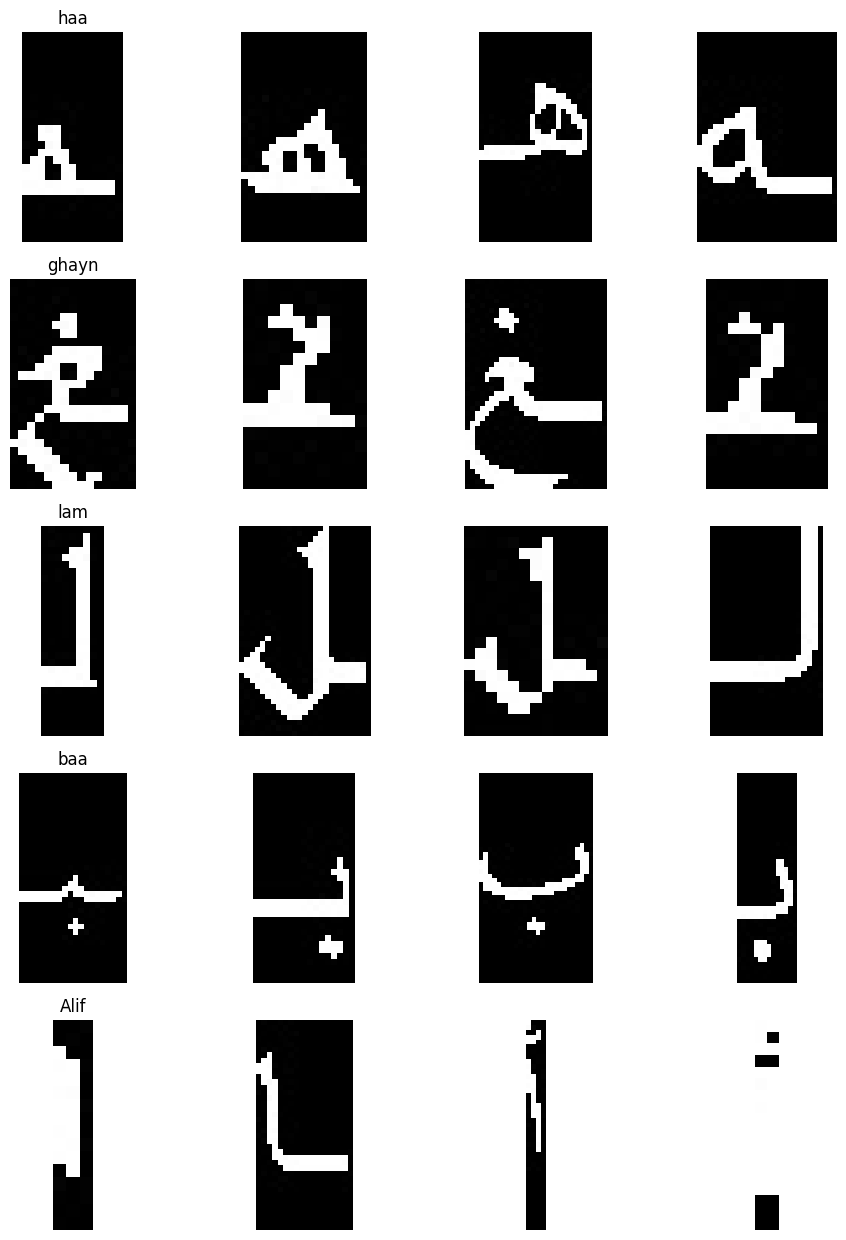

In [6]:
show_random_samples_per_class()


In [7]:
from torchvision import transforms

IMG_SIZE = 128
PADDING = 12

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(PADDING, fill=0),
    transforms.RandomAffine(
        degrees=18,
        translate=(0.12, 0.12),
        scale=(0.85, 1.15),
        shear=7,
        fill=0,
    ),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(PADDING, fill=0),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


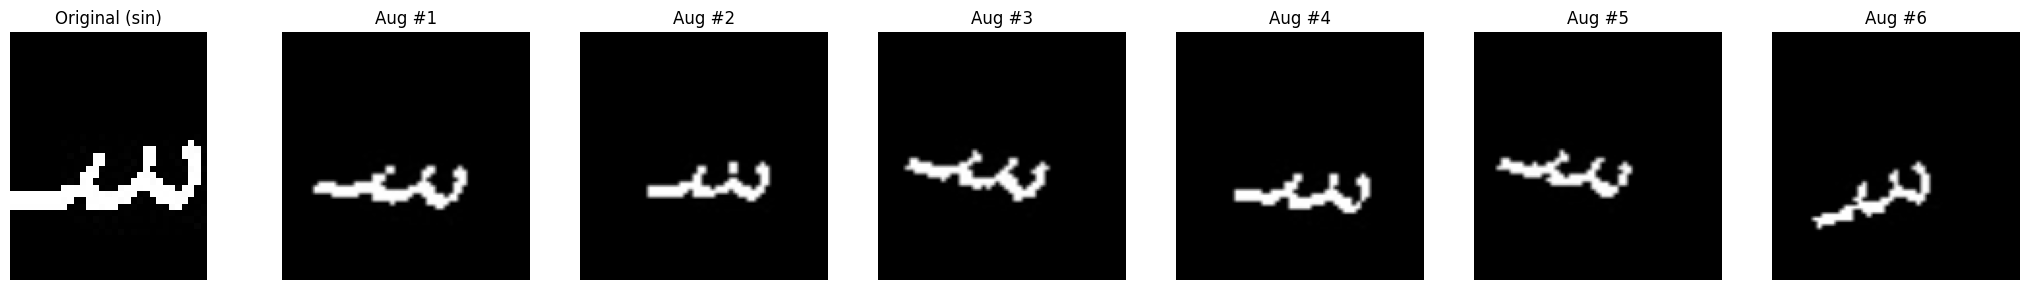

In [8]:
def show_augmentation_examples(cls=None, n_aug=6):
    # Choose random class
    classes = sorted([d for d in os.listdir(DATA_DIR) if (DATA_DIR / d).is_dir()])
    if cls is None:
        cls = random.choice(classes)

    cls_dir = DATA_DIR / cls
    files = [
        f for f in os.listdir(cls_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    ]
    assert files, f"No images found in {cls_dir}"
    fname = random.choice(files)
    fpath = cls_dir / fname

    with Image.open(fpath) as img:
        img = img.convert("L")

        plt.figure(figsize=(3 * (n_aug + 1), 3))

        # Original
        ax = plt.subplot(1, n_aug + 1, 1)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Original ({cls})")
        ax.axis("off")

        # Augmented
        for i in range(n_aug):
            aug_tensor = train_transform(img)  # (1,H,W)
            aug_img = aug_tensor.squeeze(0)
            aug_img = aug_img * 0.5 + 0.5  # unnormalize to [0,1]
            aug_img = aug_img.numpy()

            ax = plt.subplot(1, n_aug + 1, i + 2)
            ax.imshow(aug_img, cmap="gray")
            ax.set_title(f"Aug #{i+1}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

show_augmentation_examples()


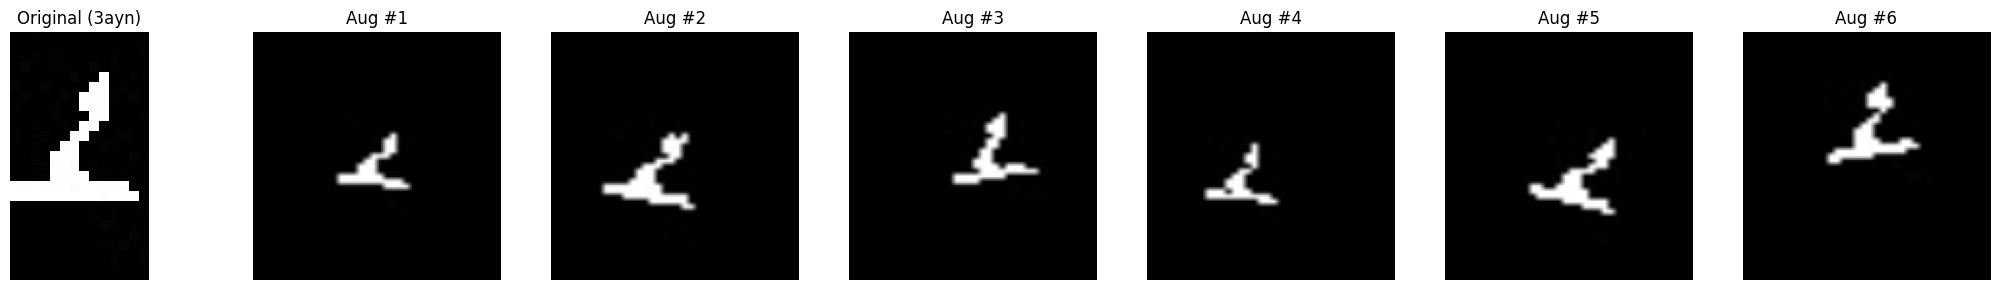

In [9]:
show_augmentation_examples(cls="3ayn")
